In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#Dependencies
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32


In [3]:
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
train_normal = len(os.listdir(os.path.join(train_dir, "NORMAL")))
train_pneumonia = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"
test_normal = len(os.listdir(os.path.join(test_dir, "NORMAL")))
test_pneumonia = len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))

val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
val_normal = len(os.listdir(os.path.join(val_dir, "NORMAL")))
val_pneumonia = len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))

In [4]:
# Data Augmentation

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/10
163/163 [==============================] - 231s 1s/step - loss: 0.5336 - accuracy: 0.7452
Epoch 2/10
163/163 [==============================] - 186s 1s/step - loss: 0.4015 - accuracy: 0.7899
Epoch 3/10
163/163 [==============================] - 186s 1s/step - loss: 0.3478 - accuracy: 0.8367
Epoch 4/10
163/163 [==============================] - 182s 1s/step - loss: 0.2930 - accuracy: 0.8681
Epoch 5/10
163/163 [==============================] - 183s 1s/step - loss: 0.2913 - accuracy: 0.8771
Epoch 6/10
163/163 [==============================] - 187s 1s/step - loss: 0.2736 - accuracy: 0.8844
Epoch 7/10
163/163 [==============================] - 186s 1s/step - loss: 0.2576 - accuracy: 0.8932
Epoch 8/10
163/163 [==============================] - 183s 1s/step - loss: 0.2373 - accuracy: 0.9024
Epoch 9/10
163/163 [==============================] - 179s 1s/step - loss: 0.2452 - accuracy: 0.8974
Epoch 10/10
163/163 [==============================] - 180s 1s/step - loss: 0.2215 - accura

19/19 [==============================] - 13s 673ms/step - loss: 0.3742 - accuracy: 0.8503
Test Loss: 0.3742145895957947
Test Accuracy: 0.8503289222717285
20/20 [==============================] - 10s 467ms/step
              precision    recall  f1-score   support

      Normal       0.39      0.27      0.32       234
   Pneumonia       0.63      0.74      0.68       390

    accuracy                           0.57       624
   macro avg       0.51      0.51      0.50       624
weighted avg       0.54      0.57      0.55       624



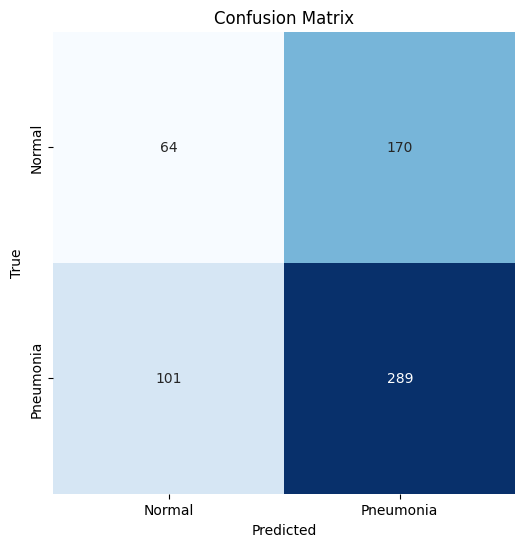

In [7]:
# Results
test_results = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)

print(classification_report(test_generator.classes, y_pred, target_names=["Normal", "Pneumonia"]))
confusion_mtx = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
